In [3]:
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

[Link to dataset](https://archive.ics.uci.edu/dataset/186/wine+quality)

In [51]:
dfr = pd.read_csv('./dataset/winequality-red.csv', sep=';')
dfw = pd.read_csv('./dataset/winequality-white.csv', sep=';')
target = 'quality'

# Dataset Features Explanation

### 1. **Fixed Acidity**
- **Definition**: The non-volatile acids that do not evaporate during fermentation, primarily tartaric acid, which contributes to the tartness of wine.
- **Impact on Wine**: Affects the wine's flavor and preservation. High fixed acidity can make the wine taste sour or sharp, while low fixed acidity might result in a flat taste.
- **Typical Range**: 4.0–15.0 g/L

### 2. **Volatile Acidity**
- **Definition**: Acids that can evaporate, such as acetic acid (the main component of vinegar).
- **Impact on Wine**: High volatile acidity can cause an unpleasant vinegar-like taste, while low levels are essential for a balanced flavor.
- **Typical Range**: 0.1–1.2 g/L

### 3. **Citric Acid**
- **Definition**: A minor acid in wine, often added to enhance freshness and increase acidity.
- **Impact on Wine**: Provides a slight citrusy flavor and enhances the perception of freshness, particularly in white wines.
- **Typical Range**: 0.0–1.0 g/L

### 4. **Residual Sugar**
- **Definition**: The amount of sugar left in wine after fermentation.
- **Impact on Wine**: Determines the sweetness level. Low residual sugar results in a dry wine, while higher levels contribute to sweeter wines.
- **Typical Range**: 0.6–20.0 g/L (can exceed 300 g/L in dessert wines)

### 5. **Chlorides**
- **Definition**: The concentration of chloride ions, which may come from natural sources or winemaking processes.
- **Impact on Wine**: Contributes to the saltiness or minerality of the wine, which can enhance complexity when balanced.
- **Typical Range**: 0.01–0.2 g/L

### 6. **Free Sulfur Dioxide**
- **Definition**: The portion of sulfur dioxide (SO₂) in wine that is not bound to other molecules and is available to act as an antimicrobial and antioxidant agent.
- **Impact on Wine**: Protects wine from oxidation and spoilage, but excessive levels can lead to unpleasant aromas.
- **Typical Range**: 1–50 mg/L

### 7. **Total Sulfur Dioxide**
- **Definition**: The total amount of sulfur dioxide, both free and bound, present in the wine.
- **Impact on Wine**: Important for preservation, but too much can impair taste and cause health concerns for sensitive individuals.
- **Typical Range**: 50–350 mg/L (regulated by wine type and laws)

### 8. **Density**
- **Definition**: The mass per unit volume of the wine, influenced by sugar and alcohol content.
- **Impact on Wine**: Used to estimate alcohol and residual sugar levels. Higher density often indicates higher sweetness.
- **Typical Range**: 0.990–1.005 g/mL

### 9. **pH**
- **Definition**: Measures the acidity level, indicating how acidic or basic the wine is.
- **Impact on Wine**: Affects stability, taste, and color. Lower pH (more acidic) preserves freshness, while higher pH can lead to spoilage if not managed.
- **Typical Range**: 2.9–4.2

### 10. **Sulphates**
- **Definition**: Compounds related to sulfur, often added to wine for preservation.
- **Impact on Wine**: Acts as an antimicrobial and antioxidant, contributing to stability and longevity. Excess levels can impart a bitter or astringent taste.
- **Typical Range**: 0.3–2.0 g/L

### 11. **Alcohol**
- **Definition**: Ethanol content produced during fermentation.
- **Impact on Wine**: Affects body, flavor, and aroma. Higher alcohol content enhances the perception of warmth and boldness.
- **Typical Range**: 8–15% (can go up to ~20% for fortified wines)

### 12. **Quality - Target Feature**
- **Definition**: A subjective score often based on sensory evaluations (e.g., taste, aroma, balance) and sometimes correlated with chemical properties.
- **Impact on Wine**: Serves as an overall indicator of the wine's acceptability and desirability to consumers and critics.
- **Typical Range**: 0–10 (in common scoring systems)

---

These traits collectively determine the wine's chemical balance, flavor profile, and market appeal. Winemakers and analysts monitor and adjust these parameters to produce wine of desired quality and style.


Let's start by examining the distibution of the target feature which is "quality":

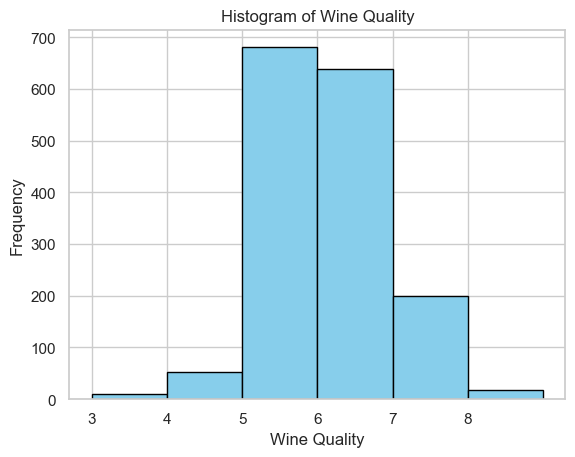

In [55]:

# Histogram for wine quality distribution
plt.hist(dfr['quality'], bins=range(dfr['quality'].min(), dfr['quality'].max() + 2), edgecolor='black', color='skyblue')
plt.title("Histogram of Wine Quality")
plt.xlabel("Wine Quality")
plt.ylabel("Frequency")
plt.xticks(range(dfr['quality'].min(), dfr['quality'].max() + 1))
plt.show()

As we can see most of our data has a quality in between 5-6.
This might cause as some porblems later to predict some very fine wines or some pretty bad ones - since most of the wines present in our data is average.

It make sense now then, to check for some specific features that have high correlations with the target feature,
We can start by using a correlations heat map of all the features with the target:

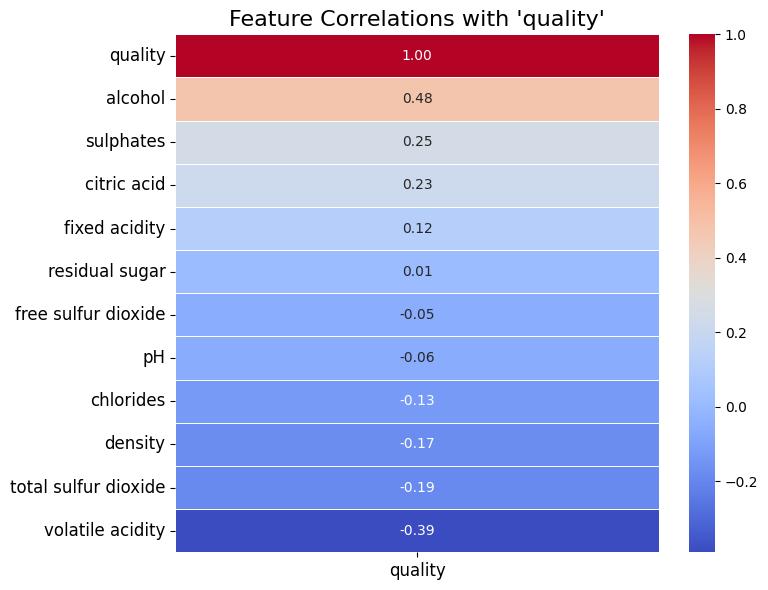

In [5]:
correlation = dfr.corr()[[target]].sort_values(by=target, ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation,
    annot=True,
    cmap='coolwarm',
    cbar=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"fontsize": 10},
)
plt.title(f"Feature Correlations with '{target}'", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


### No obvious correlation

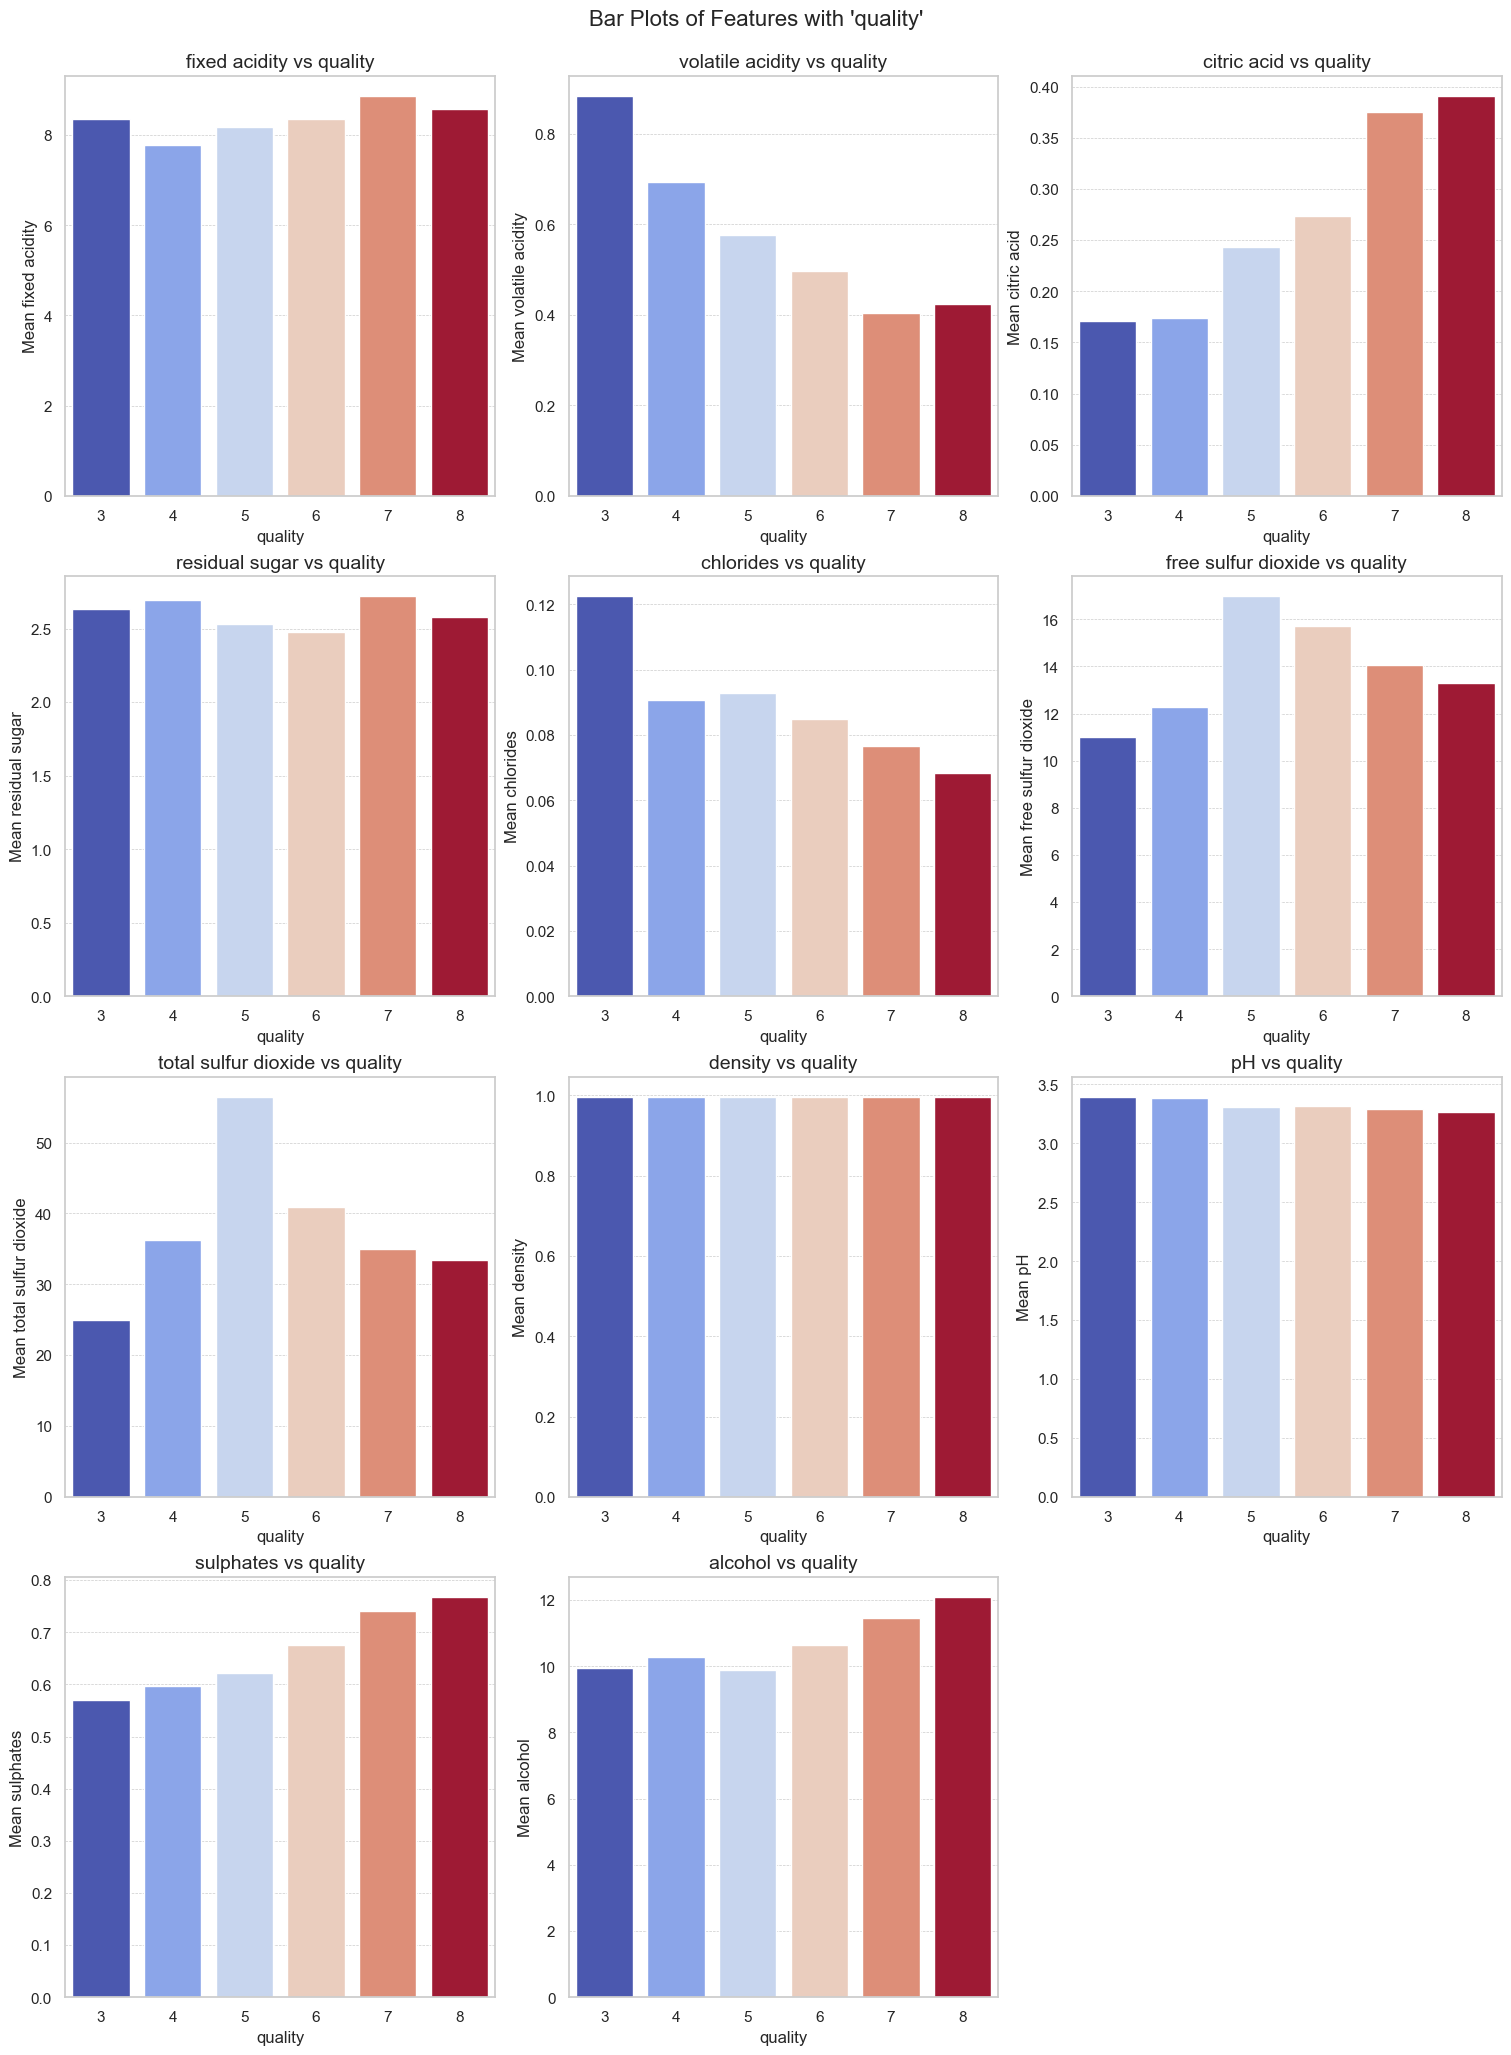

In [56]:
target = 'quality'

features = [col for col in dfr.columns if col != target]
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    feature_means = dfr.groupby(target)[feature].mean().reset_index()
    sns.barplot(data=feature_means, x=target, y=feature, ax=ax,hue=target, legend=False, palette='coolwarm')
    ax.set_title(f"{feature} vs {target}", fontsize=14)
    ax.set_xlabel(target, fontsize=12)
    ax.set_ylabel(f"Mean {feature}", fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f"Bar Plots of Features with '{target}'", fontsize=16, y=1.02)
plt.show()


### It looks like Volitile acidity, Citric Acid, Alcohol and Sulphates have some kind of correlation with quality

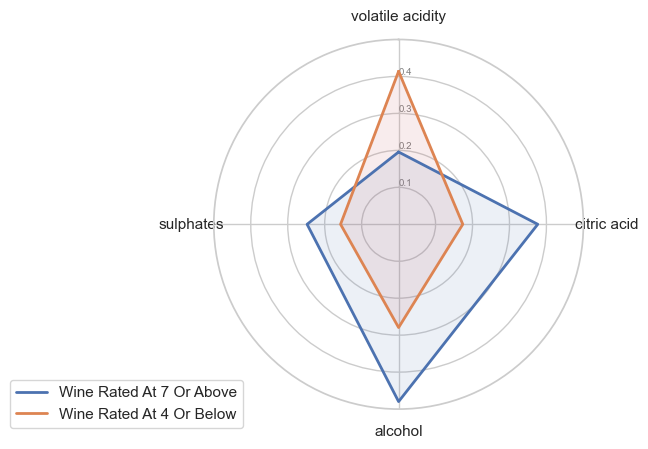

In [57]:
scaler = MinMaxScaler()
standardized_dfr = pd.DataFrame(scaler.fit_transform(dfr),columns=dfr.columns)
dfr_best = standardized_dfr[dfr.quality>=7]
dfr_worst = standardized_dfr[dfr.quality<=4]
categories = ['volatile acidity', 'citric acid', 'alcohol', 'sulphates']
N=len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
 
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
ticks = [0.1,0.2,0.3,0.4]
plt.yticks(ticks, [str(num) for num in ticks], color="grey", size=7)
plt.ylim(0,0.5)
 

values=dfr_best[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 7 Or Above")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=dfr_worst[categories].mean().values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Wine Rated At 4 Or Below")
ax.fill(angles, values, 'r', alpha=0.1)
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

### We can see that the best wines offer: 
1. More sulphates, meaning more preservation, making the wine last longer.
2. More alcohol, because who doesnt like some alcohol?
3. More citric acid, making the wine fill fresher.
4. Less volitile acidity, making the flavor more balanced

# TODO: add 2 more plots, improve explanation of each plot, barplots are too much plots, add boxplot

Let's examine now our data set using boxplt to understand it's variablity across this target feature

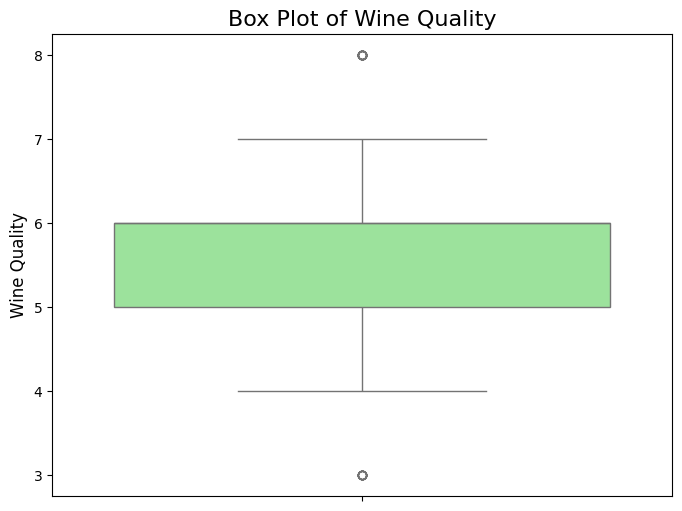

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=target, data=dfr, color="lightgreen")
plt.title("Box Plot of Wine Quality", fontsize=16)
plt.ylabel("Wine Quality", fontsize=12)
plt.show()

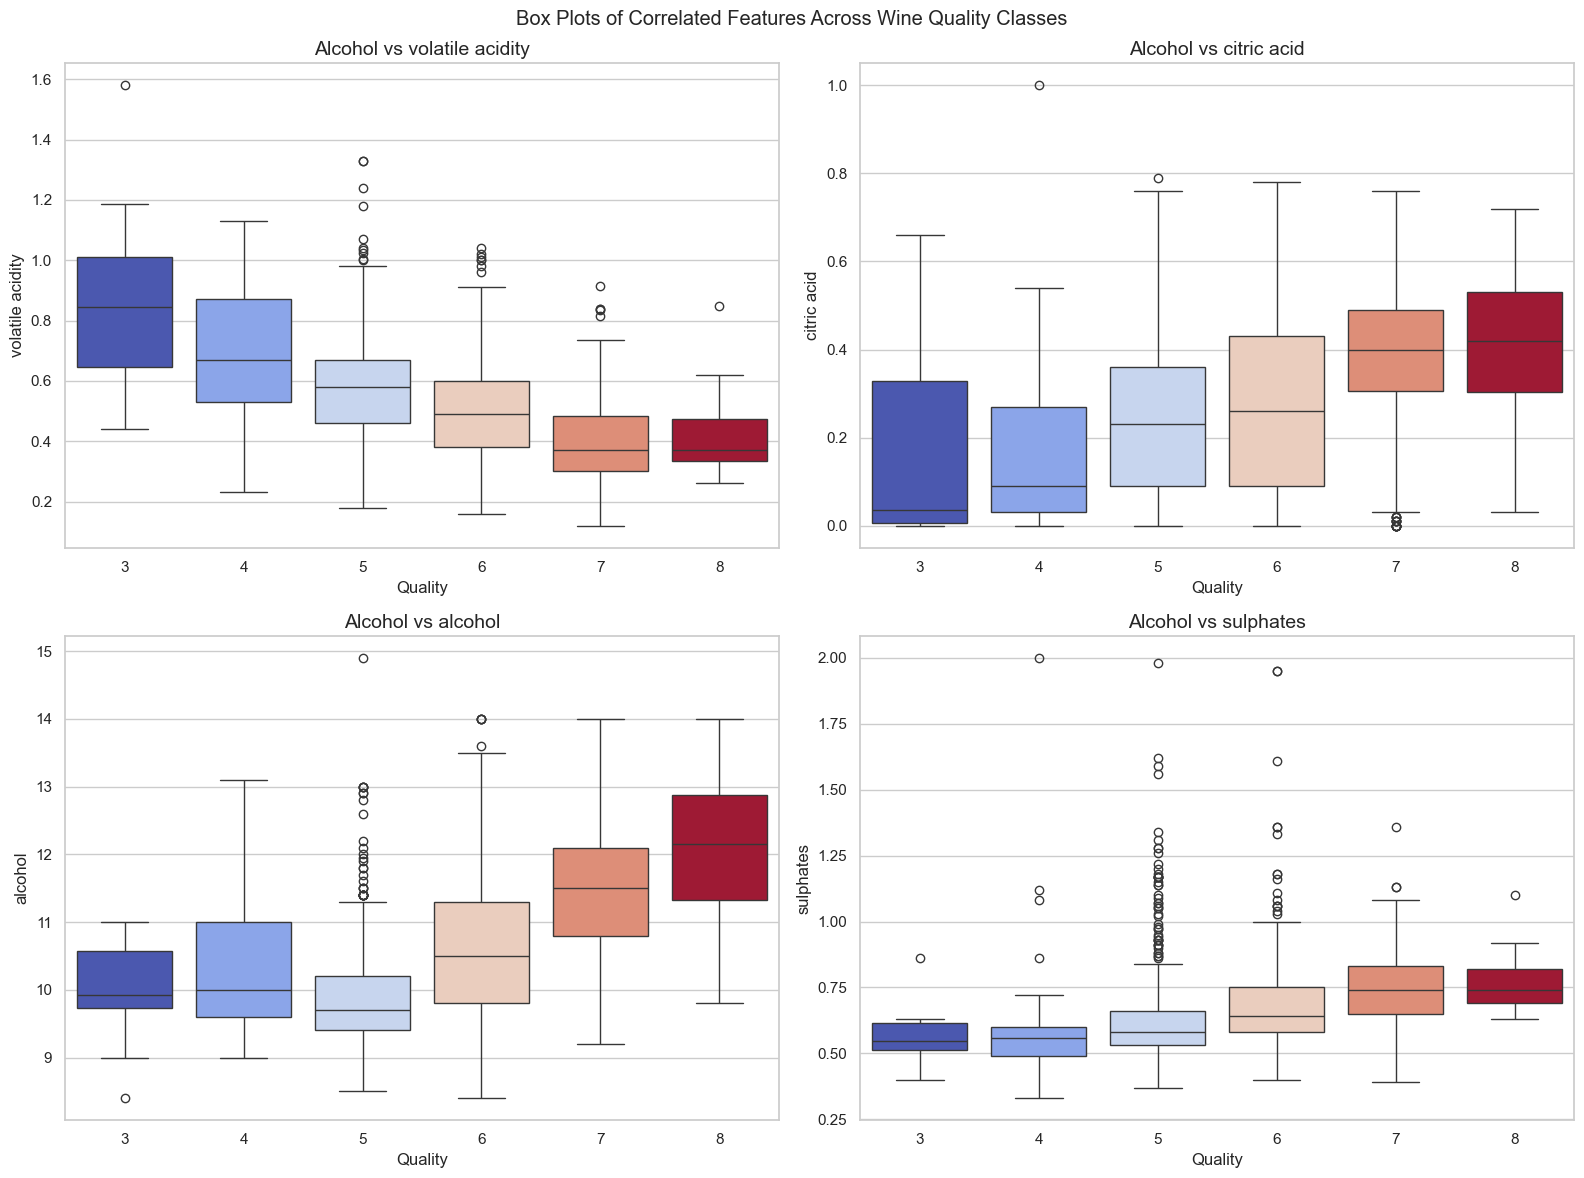

In [47]:
corelated_features = ['volatile acidity', 'citric acid', 'alcohol' ,'sulphates']

# Create a figure with a subplot for each corelated feature
fig, axes = plt.subplots(len(corelated_features)//2, 2, figsize=(16, 12))
fig.suptitle('Box Plots of Correlated Features Across Wine Quality Classes')

# Box plot for the first correlated feature (e.g., alcohol vs quality)

for idx, feature in enumerate(corelated_features):
    sns.boxplot(x=target, y=feature, hue=target, data=dfr, ax=axes[idx // 2, idx % 2], palette="coolwarm", dodge=False)
    axes[idx // 2, idx % 2].set_title(f"Alcohol vs {feature}", fontsize=14)
    axes[idx // 2, idx % 2].set_xlabel("Quality", fontsize=12)
    axes[idx // 2, idx % 2].set_ylabel(feature, fontsize=12)
    axes[idx // 2, idx % 2].legend_.remove()  # Remove the legend for cleaner visualization

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

to do: examine what informatino about the data can I get out of this

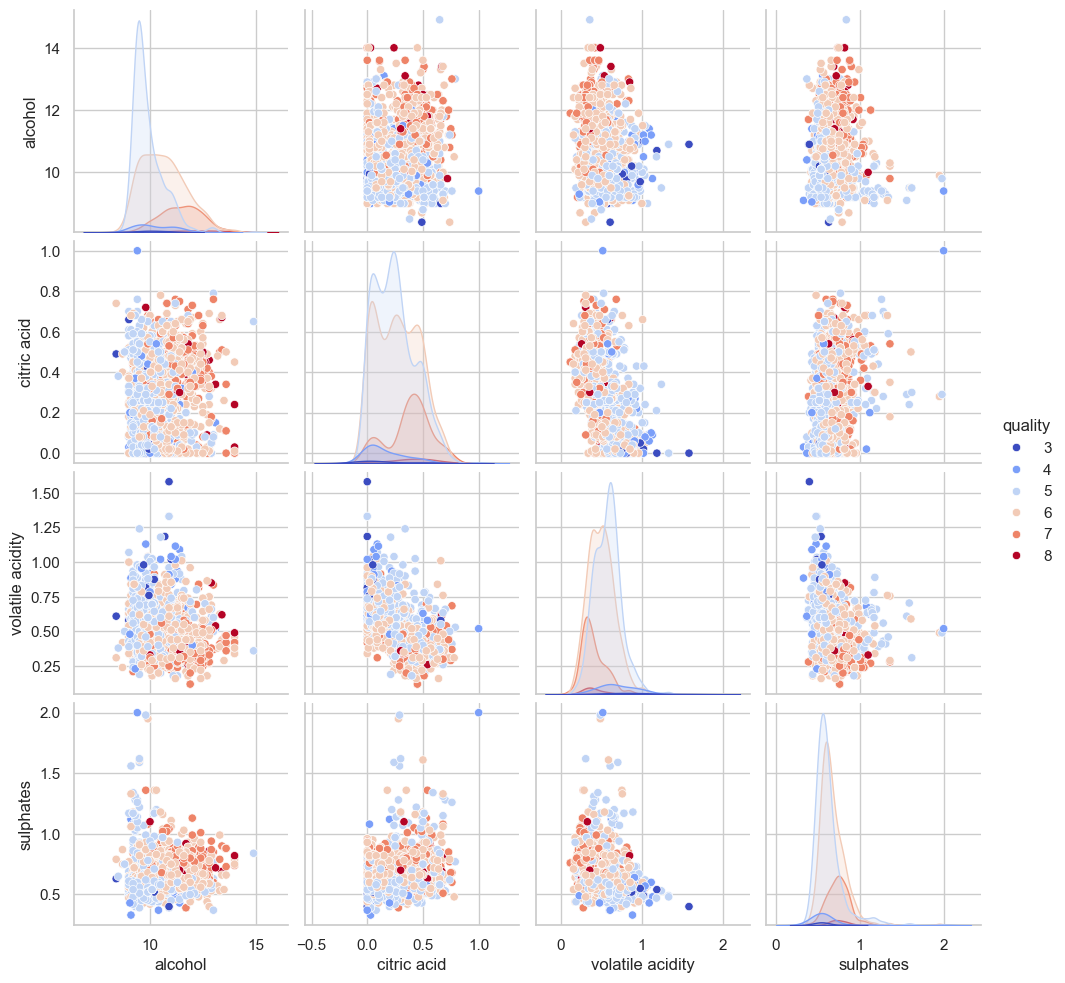

In [34]:
sns.pairplot(dfr[['quality', 'alcohol', 'citric acid', 'volatile acidity', 'sulphates']], hue='quality', palette="coolwarm")
plt.show()